# Разработка модели предсказания оттока клиентов  для оператора связи «ТелеДом»

Цель данного проекта заключается в разработке модели прогнозирования оттока клиентов для оператора связи "ТелеДом". На основе собранных персональных данных о клиентах, а также информации о их тарифах и услугах, будет обучена модель, способная предсказывать вероятность оттока клиентов, что позволит оператору принимать целенаправленные меры по удержанию клиентов и снижению оттока.

**Описание данных**

- `customerID` - идентификатор абонента

*contract_new.csv* — информация о договоре
- `BeginDate` - дата начала действия договора
- `EndDate` - дата окончания действия договора
- `Type` - тип оплаты: раз в год-два или ежемесячно
- `PaperlessBilling` - электронный расчётный лист
- `PaymentMethod` - тип платежа
- `MonthlyCharges` - расходы за месяц
- `TotalCharges` - общие расходы абонента

*personal_new.csv* - персональные данные клиента
- `gender` - пол
- `SeniorCitizen` - является ли абонент пенсионером
- `Partner` - есть ли у абонента супруг или супруга
- `Dependents` - есть ли у абонента дети

*internet_new.csv* - информация об интернет-услугах
- `InternetService` - тип подключения
- `OnlineSecurity` - блокировка опасных сайтов
- `OnlineBackup` - облачное хранилище файлов для резервного копирования данных
- `DeviceProtection` - антивирус
- `TechSupport` - выделенная линия технической поддержки
- `StreamingTV` - стриминговое телевидение
- `StreamingMovies` - каталог фильмов

*phone_new.csv* - информация об услугах телефонии
- `MultipleLines` - подключение телефона к нескольким линиям одновременно

**Цель проекта** 
ROC AUC > 85

In [2]:
import os
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
import seaborn as sns
import phik
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

from catboost import CatBoostClassifier

from wordcloud import WordCloud

warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
RANDOM_STATE = 80424

In [4]:
def build_hist(col_name):
    """
    Строит гистограмму для сравнения распределения значений заданного признака
    в зависимости от статуса договора.

    Параметры:
    col_name (str): Название признака данных, для которого будет построена гистограмма.

    """
    contract_terminated = full_data[full_data['ActingContract'] == 1][col_name]
    contract_kept = full_data[full_data['ActingContract'] == 0][col_name]
    
    # Создаем новую фигуру с заданным размером
    plt.figure(figsize=(12, 6))
    
    plt.hist(contract_kept, alpha=0.7, label='Договор активен')
    plt.hist(contract_terminated, alpha=0.7, label='Договор расторгнут')
    
    plt.grid(True)
    
    plt.title(f'Распределение значений признака {col_name}')
    plt.xlabel(col_name)
    plt.ylabel('Кол-во')
    
    plt.legend()
    
    plt.show()
    

def select_non_collinear_features_phik(df, target_column, threshold=0.90):
    """
    Выбирает неколлинеарные признаки на основе матрицы Phik.

    Параметры:
    - df (DataFrame): DataFrame, содержащий набор данных.
    - target_column (str): Название целевого признака.
    - threshold (float): Пороговое значение для определения коллинеарности.

    Возвращает:
    - selected_features (list): Список неколлинеарных признаков.
      
    """
    df_copy = df.drop(columns=[target_column])

    phik_matrix = df_copy.phik_matrix(interval_cols=interval_columns)

    upper = phik_matrix.where(np.triu(np.ones(phik_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    selected_features = [column for column in df_copy.columns if column not in to_drop]

    selected_features.append(to_drop[0])
    selected_features.append('ActingContract')
    
    return selected_features


## Загрузка данных

**contract_new.csv**

In [5]:
pth_contract_1 = 'contract_new.csv'
pth_contract_2 = '/datasets/contract_new.csv'

if os.path.exists(pth_contract_1):
    contract = pd.read_csv(pth_contract_1, index_col='customerID')
elif os.path.exists(pth_contract_2):
    contract = pd.read_csv(pth_contract_2, index_col='customerID')
else:
    print('There is no such file')

**personal_new.csv**

In [6]:
pth_personal_1 = 'personal_new.csv'
pth_personal_2 = '/datasets/personal_new.csv'

if os.path.exists(pth_personal_1):
    personal = pd.read_csv(pth_personal_1, index_col='customerID')
elif os.path.exists(pth_personal_2):
    personal = pd.read_csv(pth_personal_2, index_col='customerID')
else:
    print('There is no such file')

**internet_new.csv**

In [7]:
pth_interner_1 = 'internet_new.csv'
pth_interner_2 = '/datasets/internet_new.csv'

if os.path.exists(pth_interner_1):
    internet = pd.read_csv(pth_interner_1, index_col='customerID')
elif os.path.exists(pth_interner_2):
    internet = pd.read_csv(pth_interner_2, index_col='customerID')
else:
    print('There is no such file')

**phone_new.csv**

In [8]:
pth_phone_1 = 'phone_new.csv'
pth_phone_2 = '/datasets/phone_new.csv'

if os.path.exists(pth_phone_1):
    phone = pd.read_csv(pth_phone_1, index_col='customerID')
elif os.path.exists(pth_phone_2):
    phone = pd.read_csv(pth_phone_2, index_col='customerID')
else:
    print('There is no such file')

## Первичный анализ и предобработка данных

### Анализ и предобработка contract(информация о договоре)

In [9]:
ProfileReport(contract, title="Contract")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Из анализа видно, что тип признака TotalCharges был неверно определен. Проведем дополнительный анализ данного признака, чтобы изучить причины возникновения ошибки.

In [10]:
numeric_values = pd.to_numeric(contract['TotalCharges'], errors='coerce')
non_numeric_rows = contract[numeric_values.isna()]
non_numeric_rows

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,


**Первичный анализ Contract:**

Отсутствуют пропущенные значения, однако имеются дубликаты.
- **BeginDate** данные охватывают период с 01.10.2013 по 01.02.2020 и характеризуются бимодальным распределением, с пиками в окрестностях 2013 и 2019 годов.
- **EndDate** в данных присутствует текстовое значение "no", которое указывает на то, что договор был активен на 01.02.2020. 
- **Type** 55% клиентов выбирают оплату услуг помесячно, 24.1% заключают контракт на два года, а 20.9% предпочитают контракт на год.
- **PaperlessBilling** 59.2% клиентов не используют бумажный чек.
- **PaymentMethod** 33.6% клиентов предпочитают в качестве оплаты электронный чек, 22.9% - почтовый чек, 21.9% - банковский перевод, а 21.6% - кредитную карту.
- **MonthlyCharges** платежи за месяц также демонстрируют бимодальное распределение с пиками около значений 20 и 80. Медианное значение составляет 70.35. Однако сильнее всего выделяются значения в окрестности 20.
- **TotalCharges** ошибка в определении типа данных столбца TotalCharges связана с тем, что данный признак не был заполнен для новых клиентов, у которых еще не было накопленно общих расходов.

**Выводы**:
1) Необходимо избавиться от столбцов BeginDate и EndDate, так как они привязывают нас к определенным временным промежуткам, что может негативно сказаться на будущих предсказаниях. На их основе создадим два новых столбца: ActingContract, где 0 будет соответствовать данным, у которых в признаке EndDate значение равно "No", и 1 - для тех, у кого в этом признаке содержится дата. Далее заменим 'no' на 01.02.2020. Также мы добавим столбец ContractDuration, в котором будет указана продолжительность контракта.

2) Для новых клиентов заменим отсутствующие значения в признаке TotalCharges на значения из столбца MonthlyCharges, поскольку  в данном контексте их ежемесячные расходы будут считаться их общими расходами.

3) ActingContract будетнашим целевым признаком, поскольку он указывает на тех клиентов, которые расторгли контракт.

In [11]:
#Обработка дат
contract['ActingContract'] = contract['EndDate'].apply(lambda x: 0 if x == 'No' else 1)
contract['EndDate'] = contract['EndDate'].apply(lambda x: '2020-02-01' if x == 'No' else x)

#Вычисление продолжительности контракта
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['EndDate'] = pd.to_datetime(contract['EndDate'])
contract['ContractDuration'] = (contract['EndDate'] - contract['BeginDate']).dt.days

#Удаление ненужных признаков
contract = contract.drop(['BeginDate', 'EndDate'], axis=1)

#Обработка общих расходов
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract['TotalCharges'] = contract['TotalCharges'].fillna(contract['MonthlyCharges'])

In [12]:
display(contract.sample(5))
contract.info()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ActingContract,ContractDuration
customerID,,,,,,,
0060-FUALY,Month-to-month,Yes,Electronic check,94.75,5981.57,0,1798
0067-DKWBL,Month-to-month,Yes,Electronic check,49.25,197.00,0,123
7797-EJMDP,Month-to-month,No,Bank transfer (automatic),66.05,549.54,0,245
4137-BTIKL,Month-to-month,No,Mailed check,90.75,181.50,0,62
7404-JLKQG,Month-to-month,No,Electronic check,57.55,174.38,0,92


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   ActingContract    7043 non-null   int64  
 6   ContractDuration  7043 non-null   int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 698.2+ KB


### Анализ и предобработка personal(персональные данные клиента)

In [13]:
ProfileReport(personal, title="Personal")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Первичный анализ Personal:**

Отсутствуют пропущенные значения, однако имеются дубликаты.

- **gender** среди клиентов наблюдается небольшое преобладание мужчин, составляющее 50.5%, по сравнению с 49.5% женщин.
- **SeniorCitizen** большинство клиентов не являются пенсионерами, их доля составляет 83.8%, в то время как пенсионеров составляют лишь 16.2%.
- **Partner** у 51.7% клиентов отсутствует супруг/супруга.
- **Dependents** 70% не имеют детей.

**Выводы:** 

1) Приведём название колонки "gender" к нормализованному виду.

2) Для нормализации столбца SeniorCitizen относительно других данных заменим 0 на No и 1 на Yes.

In [14]:
personal = personal.rename(columns={'gender': 'Gender'})
personal['SeniorCitizen'] = personal['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})
personal.sample(5)

,Gender,SeniorCitizen,Partner,Dependents
customerID,,,,
0137-OCGAB,Female,No,No,No
9374-YOLBJ,Female,No,Yes,Yes
3179-GBRWV,Male,Yes,Yes,No
5233-GEEAX,Male,Yes,No,No
2907-ILJBN,Female,No,Yes,Yes


### Анализ и предобработка internet(информация об интернет-услугах)

In [15]:
ProfileReport(internet, title="Internet")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Первичный анализ Internet:**

Отсутствуют пропущенные значения, однако имеются дубликаты.

- **IntenetService** большинство клиентов, а именно 56.1%, используют Fiber optic (оптоволоконный кабель).
- **OnlineSecurity** 66.4% клиентов пользуются функцией блокировки опасных сайтов.
- **OnlineBackup** 44% клиентов пользуются функцией облачного хранения данных.
- **DeviceProtection** 43.9% клиентов пользуются функцией антивируса.
- **TechSupport** 37% клиентов пользуются выделенной линией технической поддержки.
- **StreamingMovies** 49.1% клиентов пользуются стриминговым телевидением.
- **StreamingMovies** 49.5% клиентов пользуются каталогом фильмов.

**Выводы:** 

Все вышеперечисленные признаки оставим без изменений.

### Анализ и предобработка phone(информация об услугах телефонии)

In [16]:
ProfileReport(phone, title="Phone")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Первичный анализ Phone:**

Отсутствуют пропущенные значения, однако имеются дубликаты.

- **MultipleLines** 53.3% клиентов не пользуются подключением телефона к нескольким линиям.

**Выводы:** 

Все вышеперечисленные признаки оставим без изменений.

## Объединение данных

Так как наиболее полная информация о пользователях содержится в таблицах personal и contract, а остальные таблицы могут быть не полностью заполнены из-за того, что клиенты не пользовались определенными функциями, мы будем присоединять все остальные таблицы к таблице personal.

Пропущенные значения после объединения таблиц указывают на то, что пользователь вообще не пользовался соответствующей функцией. Поэтому целесообразно заполнить эти пропуски значением "NotUsed".

In [17]:
full_data = pd.merge(personal, contract, left_index=True, right_index=True, how='inner')
full_data = pd.merge(full_data, internet, left_index=True, right_index=True, how='left')
full_data = pd.merge(full_data, phone, left_index=True, right_index=True, how='left')
full_data.fillna('NotUsed', inplace=True)
display(full_data.sample(5))
print(f'Размер таблицы после объединения - {full_data.shape}')

,Gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ActingContract,ContractDuration,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
9530-GRMJG,Male,No,Yes,Yes,Two year,Yes,Electronic check,84.10,3532.20,1,1279,DSL,No,Yes,Yes,Yes,Yes,Yes,Yes
8774-GSBUN,Male,No,Yes,No,Two year,No,Mailed check,25.40,1828.80,0,2191,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,Yes
0487-VVUVK,Male,No,Yes,Yes,Month-to-month,Yes,Mailed check,19.15,502.69,0,761,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,No
8603-IJWDN,Male,No,No,No,Month-to-month,Yes,Electronic check,86.60,285.78,0,92,Fiber optic,No,No,No,No,No,Yes,Yes
1429-UYJSV,Female,No,No,No,One year,No,Mailed check,19.70,257.68,0,365,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,NotUsed,No


Размер таблицы после объединения - (7043, 19)


Объединение таблиц выполнено успешно: размеры совпадают, пропуски заполнены.

## Исследовательский анализ данных

### Распределения значений признаков в зависимости от статуса договора

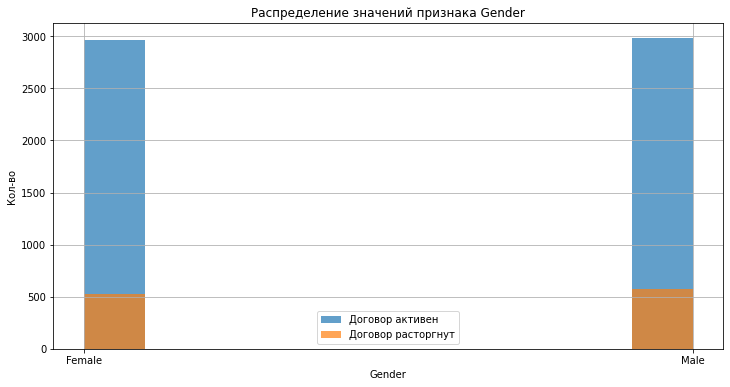

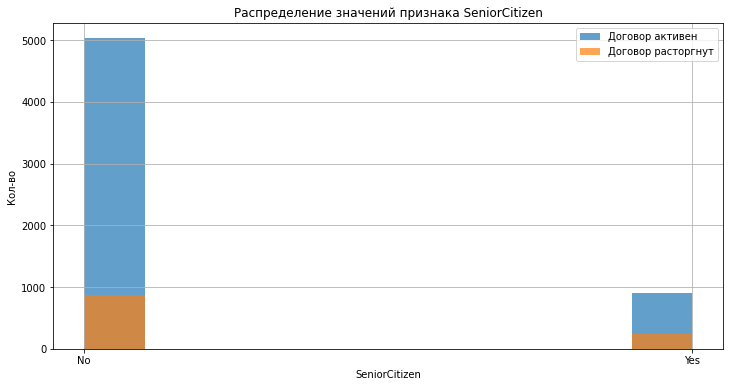

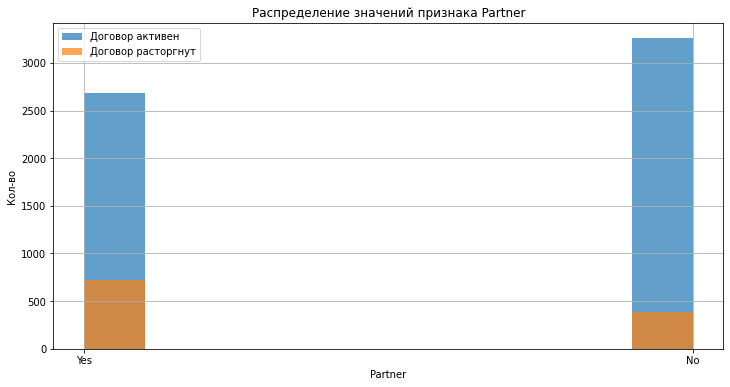

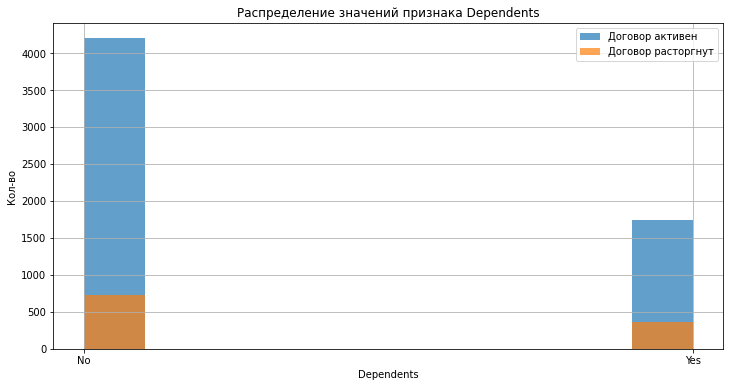

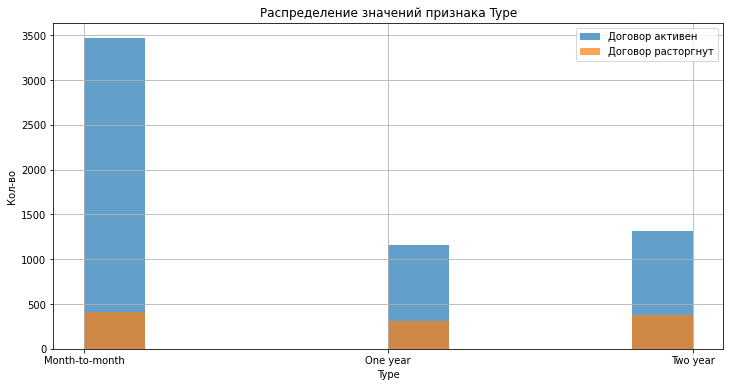

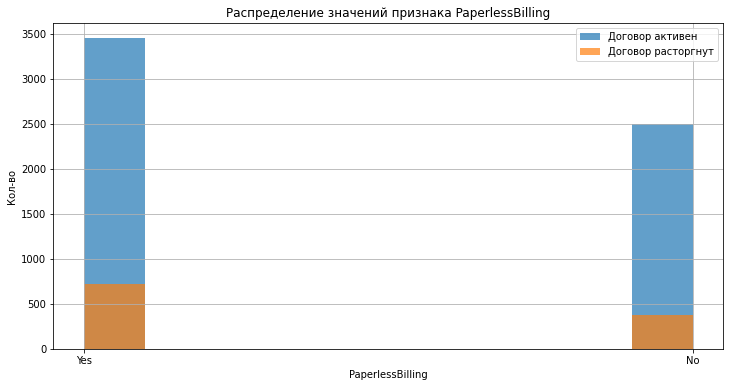

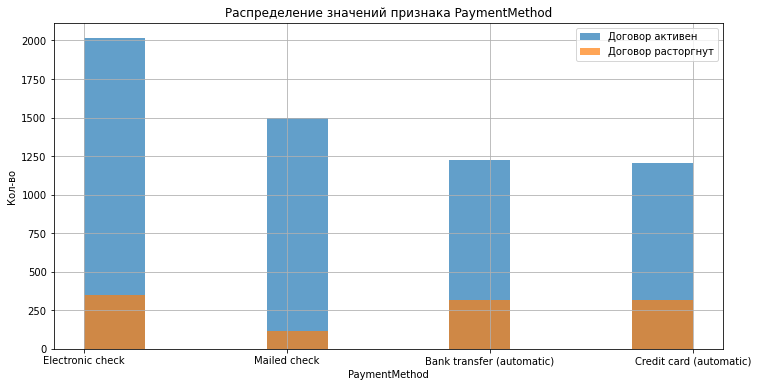

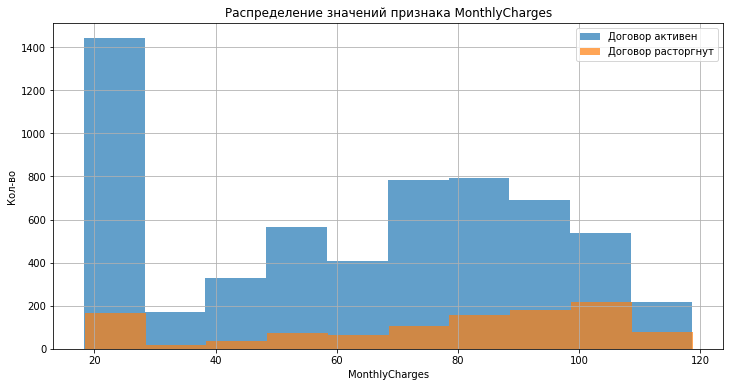

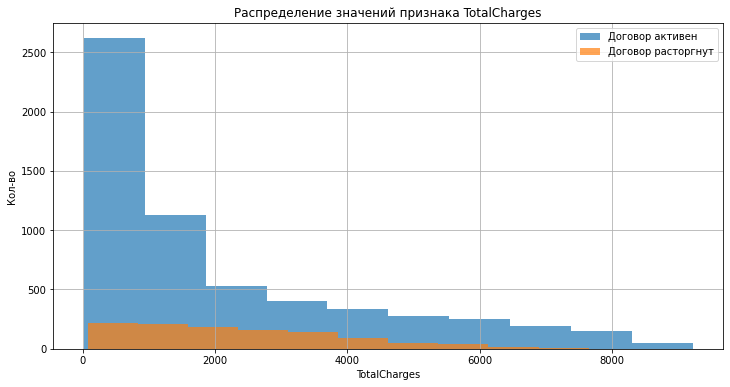

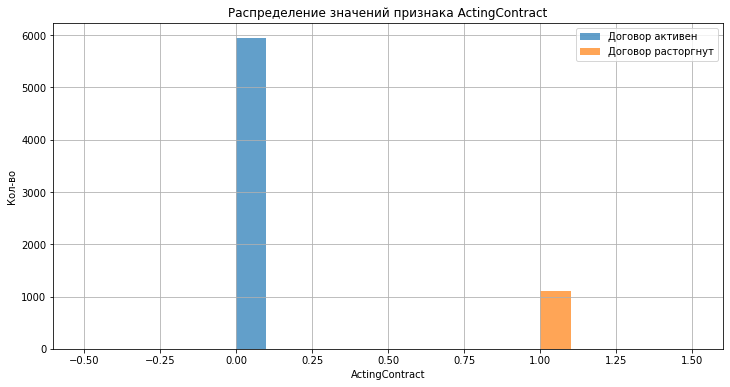

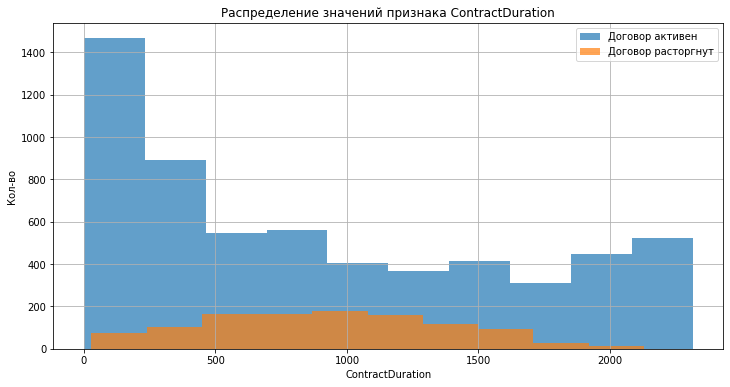

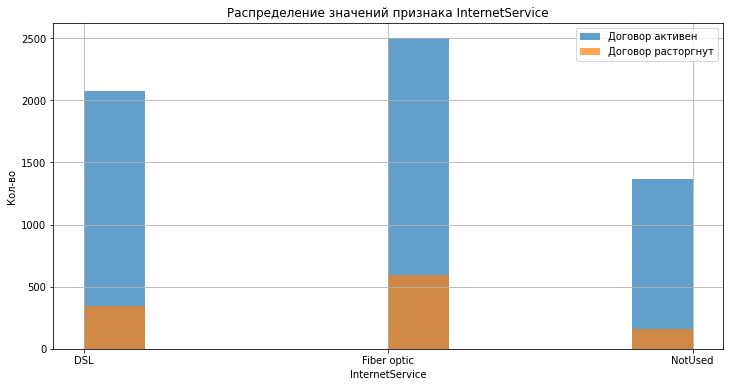

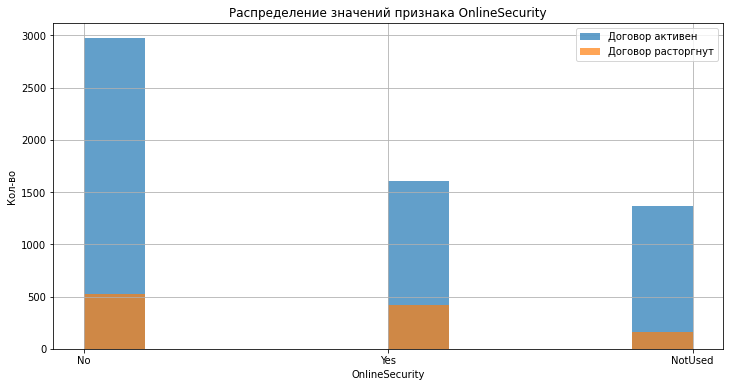

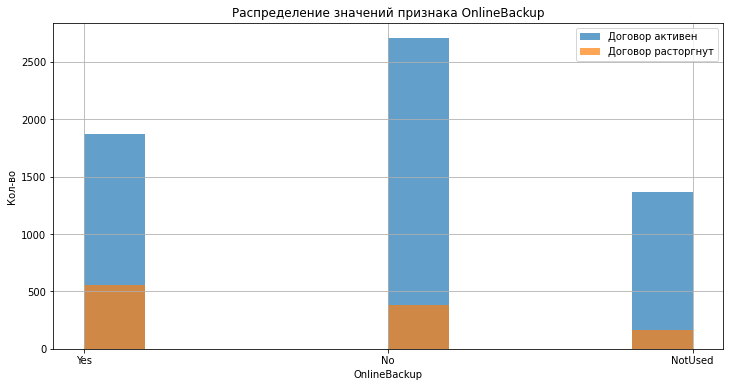

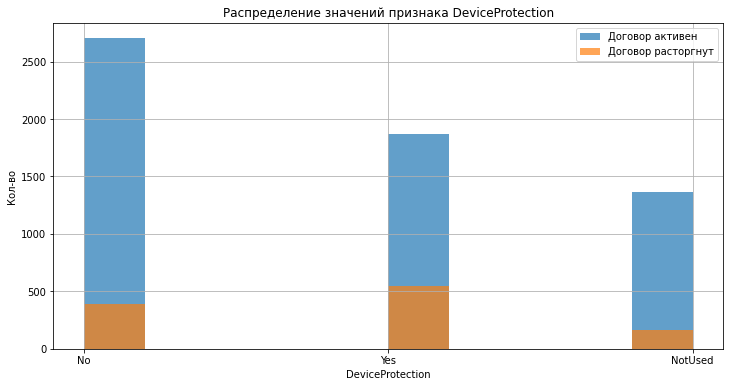

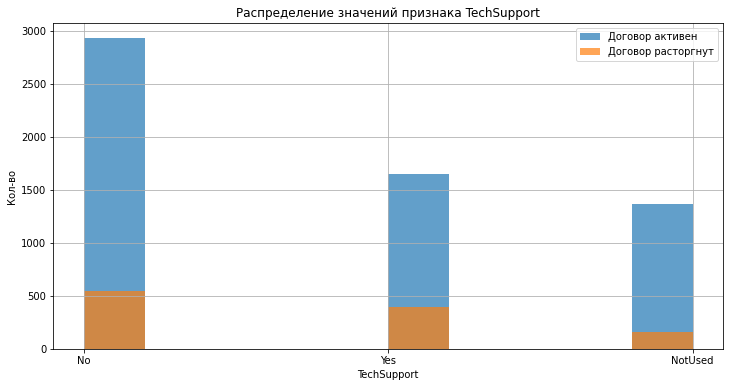

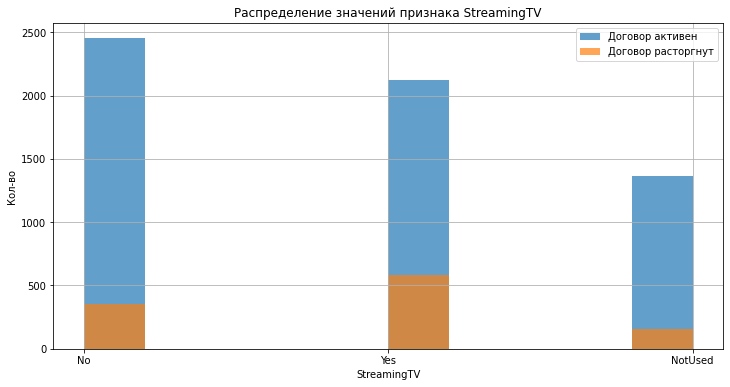

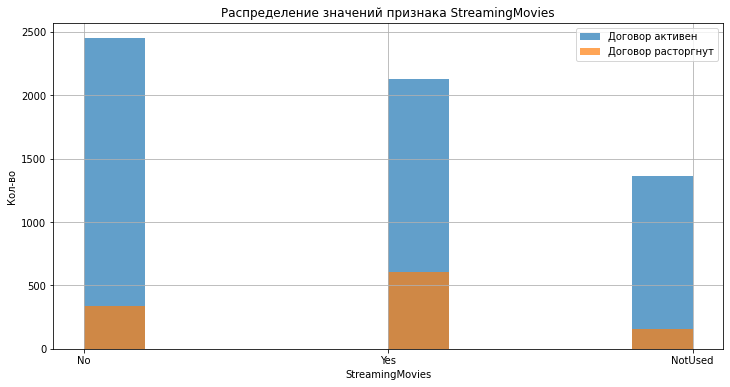

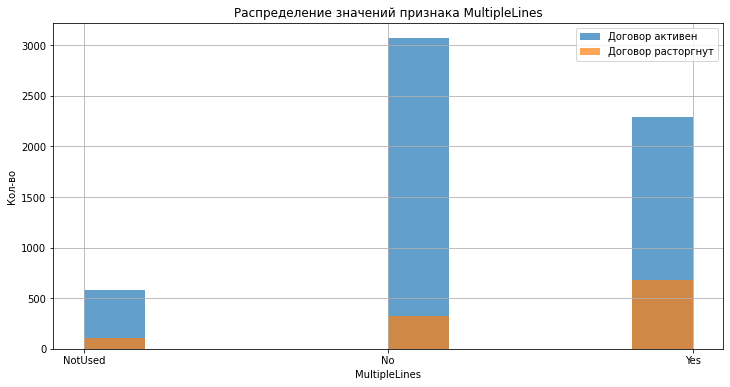

In [18]:
for feature in full_data.columns:
    build_hist(feature)

На основании анализа графиков можно сделать вывод, что среди клиентов, использующих дополнительные услуги, процент разрыва контракта выше, чем у клиентов, не пользующихся данными услугами. Также примечательно, что распределения продолжительности действия контракта различаются: у тех, кто расторг контракт, оно имеет более нормальную форму с пиком в окрестности 1000 дней. Кроме того, среди пользователей, оплачивающих услуги банковскими переводами и кредитными картами, процент разрыва контракта также выше. Аналогично выше процент разрыва для клиентов, оплачивающих контракт на год или два, а также для тех, у кого имеется супруг или супруга.

### Корреляционный анализ

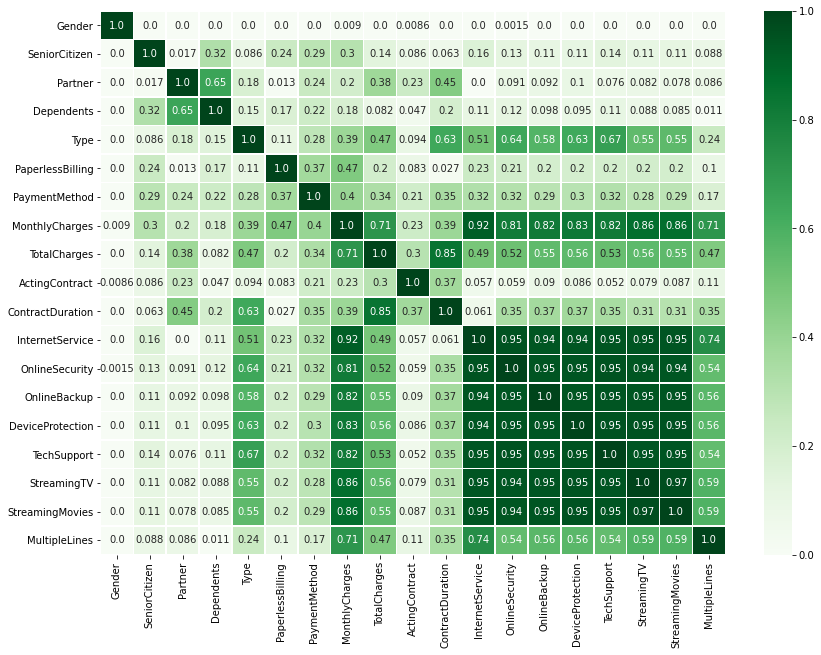

In [19]:
plt.figure(figsize=(14, 10))

interval_columns = ['MonthlyCharges', 'TotalCharges', 'ContractDuration']

heatmap = sns.heatmap(full_data.phik_matrix(interval_cols=interval_columns),
                      annot=True, cmap='Greens', linewidths=0.5, fmt='.2');

Из анализа тепловой карты коэффициентов корреляции можно сделать вывод, что наиболее сильно коррелируют с целевым признаком ActingContract такие признаки, как Partner, PaymentMethod, MonthlyCharges, TotalCharges и ContractDuration.

Кроме того, установим порог мультиколлинеарности на уровне 0.90 и исключим признаки, имеющие коэффициент корреляции выше этого значения.

In [20]:
selected_features = select_non_collinear_features_phik(full_data, target_column='ActingContract', threshold=0.9)
print("Признаки без мультиколлинеарности:\n", selected_features)

Признаки без мультиколлинеарности:
 ['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'ContractDuration', 'MultipleLines', 'InternetService', 'ActingContract']


Мы исключили мультиколлинеарные признаки, оставив только те, которые будут полезны для нашей модели.

## Подготовка данных

### Подготовка финальной таблицы

In [21]:
#Таблциа без мультиколлинеарных признаков
final_data = full_data[selected_features]

In [22]:
features = final_data.drop(['ActingContract'], axis=1)
target = final_data['ActingContract']

In [23]:
num_cols = list(features.select_dtypes(include='number').columns)
cat_cols = list(features.select_dtypes(exclude='number').columns)

### Деление данных на выборки

In [24]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(5282, 12) (1761, 12) (5282,) (1761,)


Данные успешно подготовлены и готовы для обучения модели.

## Обучение моделей

In [25]:
#Обработка числовых и категориальных значений
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ],
    remainder='passthrough'
)

### LogisticRegression

In [26]:
model_lr = LogisticRegression(random_state=RANDOM_STATE)

pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model_lr)
])

param_grid_lr = {
    'preprocessor__num': [StandardScaler(), RobustScaler()],
    'classifier__C': [0.001, 0.01, 0.1, 1],
    'classifier__penalty': ['l1', 'l2']
}

grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=3, scoring='roc_auc')

grid_search_lr.fit(features_train, target_train)

best_params_lr = grid_search_lr.best_params_
roc_auc_score_lr = grid_search_lr.best_score_

In [27]:
print(f'ROC AUC LogisticRegression: {roc_auc_score_lr}')
print("Лучшие параметры LogisticRegression:")
print(best_params_lr)

ROC AUC LogisticRegression: 0.7608323084802996
Лучшие параметры LogisticRegression:
{'classifier__C': 1, 'classifier__penalty': 'l2', 'preprocessor__num': RobustScaler()}


### RandomForestClassifier

In [28]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model_rf)
])

param_grid_rf = {
    'preprocessor__num': [StandardScaler(), RobustScaler()],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='roc_auc')

grid_search_rf.fit(features_train, target_train)

best_params_rf = grid_search_rf.best_params_
roc_auc_score_rf = grid_search_rf.best_score_

In [29]:
print(f'ROC AUC Random Forest: {roc_auc_score_rf}')
print("Лучшие параметры Random Forest:")
print(best_params_rf)

ROC AUC Random Forest: 0.827090280816415
Лучшие параметры Random Forest:
{'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300, 'preprocessor__num': StandardScaler()}


### CatBoost

In [30]:
model_cb = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)

pipeline_cb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model_cb)
])


param_grid_cb = {
    'preprocessor__num': [StandardScaler(), RobustScaler()],
    'classifier__depth': [2, 4, 6],
    'classifier__iterations': [200, 400, 600],
    'classifier__learning_rate': [0.01, 0.1,]
}


grid_search_cb = GridSearchCV(pipeline_cb, param_grid_cb, cv=3, scoring='roc_auc')
grid_search_cb.fit(features_train, target_train)

best_params_cb = grid_search_cb.best_params_
roc_auc_score_cb = grid_search_cb.best_score_ 

In [31]:
print(f'ROC AUC CatBoost: {roc_auc_score_cb}')
print("Лучшие параметры CatBoost:")
print(best_params_cb)

ROC AUC CatBoost: 0.9016828039316881
Лучшие параметры CatBoost:
{'classifier__depth': 4, 'classifier__iterations': 600, 'classifier__learning_rate': 0.1, 'preprocessor__num': StandardScaler()}


## Анализ результатов и выбор модели

### Выбор модели

In [32]:
index = ['LogisticRegression',
         'RandomForest',
         'CatBoost'
        ]


data = {'ROC_AUC':[roc_auc_score_lr,
                roc_auc_score_rf,
                roc_auc_score_cb
                ]}

model_rating = pd.DataFrame(data=data, index=index)
model_rating.sort_values(by=['ROC_AUC'], ascending=False)

,ROC_AUC
CatBoost,0.901683
RandomForest,0.827090
LogisticRegression,0.760832


Исходя из результатов кросс-валидации, наилучшую эффективность показала модель CatBoost, демонстрируя среднее значение ROC AUC на уровне 0.90.

### Проверка лучшей модели на тестовых данных

In [33]:
target_predict_proba_test = grid_search_cb.best_estimator_.predict_proba(features_test)[:, 1]
target_predict_test = grid_search_cb.best_estimator_.predict(features_test)

print(f'ROC AUC на тестовой выборке: {roc_auc_score(target_test, target_predict_proba_test)}')
print(f'Accuracy на тестовой выборке: {accuracy_score(target_test, target_predict_test)}')

ROC AUC на тестовой выборке: 0.9188019102990035
Accuracy на тестовой выборке: 0.9375354911981828


Исходя из результатов на тестовой выборке, мы можем утверждать о высокой работоспособности нашей модели, поскольку она корректно предсказывает результаты в 93% случаев.

### Анализ работы модели

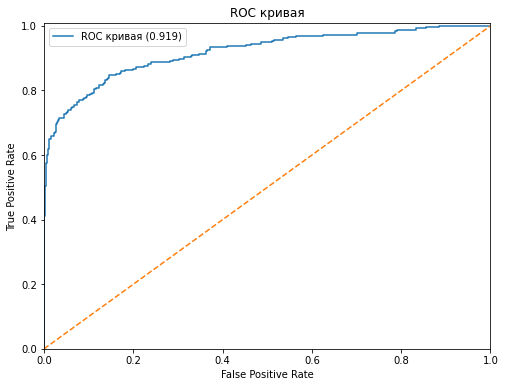

In [34]:
fpr, tpr, thresholds = roc_curve(target_test, target_predict_proba_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC кривая (%0.3f)' % roc_auc_score(target_test, target_predict_proba_test))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend()
plt.show()

ROC-кривая сильно выпукла вверх и занимает большую часть прямоугольника, это указывает на высокую производительность модели.

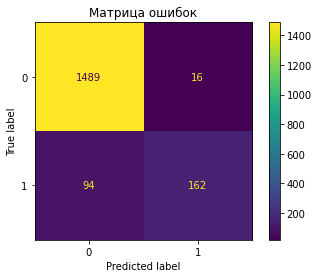

In [35]:
conf_matrix = confusion_matrix(target_test, target_predict_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=grid_search_cb.best_estimator_.classes_)

cm_display.plot()
plt.title('Матрица ошибок')
plt.show();

Из анализа матрицы ошибок видно, что модель имеет высокую точность в предсказании клиентов, которые не расторгли договор, так как большинство примеров правильно классифицированы (99% верно предсказанных примеров). Однако, с предсказанием клиентов, которые расторгли договор, модель делает значительно больше ошибок, она ошибается примерно в 36% случаев.

### Анализ важности признаков

In [36]:
importances = grid_search_cb.best_estimator_.named_steps['classifier'].feature_importances_

encoder = grid_search_cb.best_estimator_.named_steps['preprocessor'].transformers_[1][1]
feature_names = encoder.get_feature_names(input_features=cat_cols)
feature_names = [name.split('_')[0] for name in feature_names]
all_feature_names = num_cols + list(feature_names)

feature_importance_dict = dict(zip(all_feature_names, importances))

for feature, importance in sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.2f}")

    

ContractDuration: 61.78
TotalCharges: 9.61
MonthlyCharges: 8.53
Type: 4.20
PaymentMethod: 2.72
Partner: 2.64
MultipleLines: 1.94
Dependents: 1.08
PaperlessBilling: 0.92
SeniorCitizen: 0.79
Gender: 0.56
InternetService: 0.37


Исходя из результатов анализа важности признаков, можно утверждать, что лидером с значительным отрывом является признак продолжительность контракта. На втором месте располагаются общие расходы, за которыми следуют месячные расходы, тип оплаты и платежа, а также присутствие партнера.

## Вывод

**Основные этапы работы**
1) Данные были загружены, проанализированы и предобработаны. В процессе анализа были добавлены новые признаки, а также был выделен целевой.

2) Исходные датафреймы были объединены в единый.

3) На объединенных данных был проведен исследовательский и корреляционный анализ, а также осуществлен отбор признаков.

4) Данные были разделены на тренировочную и тестовую выборки.

5) Были обучены три модели: LogisticRegression, RandomForest и CatBoost.

6) После обучения была выбрана и проанализирована лучшая модель.

**Рекоммендации заказчику**

Для более корректного анализа и повышения эффективности модели рекомендуется рассмотреть следующие аспекты:

- Оценка важности ушедших клиентов: Расчет влияния ушедших клиентов на бизнес может помочь определить оптимальный порог классификации. Понижение порога может повысить обнаружение ушедших клиентов, однако это может привести к увеличению числа ложноположительных результатов. Необходимо взвесить потенциальные потери от ушедших клиентов и затраты на удержание.



- Баланс классов: Сильный дисбаланс классов снижает производительность модели в предсказании минорного класса. Попытайтесь собрать больше данных для ушедших клиентов.



- Сбор дополнительной информации о клиентах: Дополнительные данные о клиентах могут улучшить качество модели. Рассмотрите возможность сбора дополнительной информации, которая может быть полезна для предсказания оттока клиентов.

**Общий вывод**

Для последующего прогнозирования оттока клиентов рекомендуется использовать модель CatBoost со следующими гиперпараметрами: `classifier__depth: 6`, `classifier__iterations: 600`, `classifier__learning_rate: 0.1`.

Наиболее важными для модели признаками оказались:
- Продолжительность договора
- Общие затраты клиента
- Месячные затраты клиента

Цель проекта была успешно достигнута. На тестовых данных модель продемонстрировала высокую эффективность, демонстрируя ROC AUC на уровне 0.918.